In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, auc, RocCurveDisplay
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer

In [2]:
# Importing datasets

BASE_URL = 'C:/Users/stede/OneDrive/locdocs/professionAI/fondamenti di machine learning/progetto finale/'
df_train = pd.read_csv(BASE_URL + 'train.csv')
df_test = pd.read_csv(BASE_URL + 'test.csv')

### Data Preprocessing

In [3]:
# Cleaning datasets from possible typing errors, and dropping the 'id' columns

df_train.columns = df_train.columns.str.strip().str.replace(' ', '_')
df_test.columns = df_test.columns.str.strip().str.replace(' ', '_')

df_train = df_train.drop(['id'], axis=1)

In [4]:
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
# Checking any possible null value

df_train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### Data Visualization

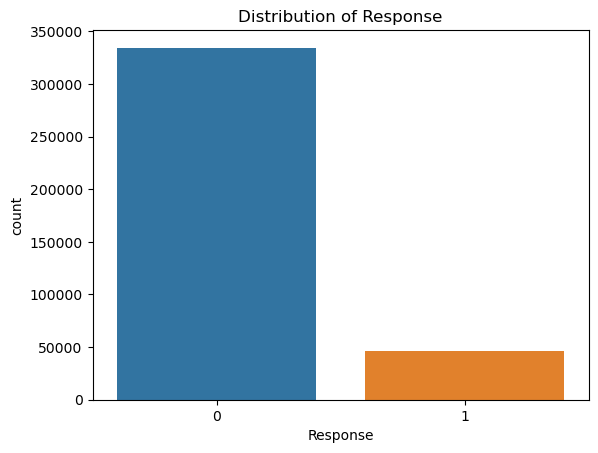

In [6]:
# Distribution of the target variable 'Response'

"""
From the graph we can see that the target variable 'Response' is strongly unbalanced.
"""

sns.countplot(x='Response', data=df_train)
plt.title('Distribution of Response')
plt.show()

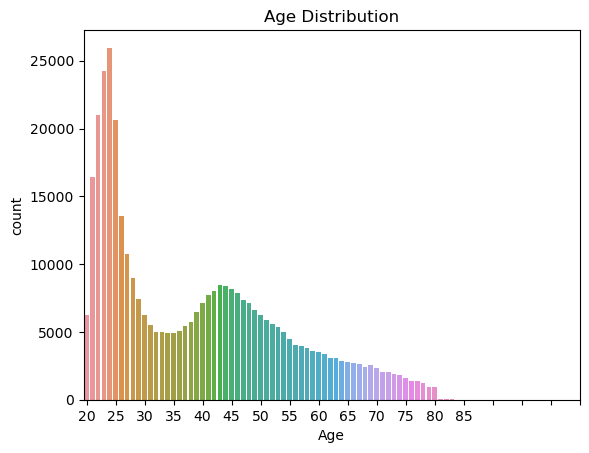

In [7]:
# Distribution of 'Age'

sns.countplot(x='Age', data=df_train)
plt.title('Age Distribution')
plt.xticks(range(0, df_train['Age'].max()+1, 5))
plt.show()

In [8]:
# Dividing categorical variables ('cat_var') and numerical variables ('num_var')

cat_var = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
num_var = ['Age', 'Vintage', 'Annual_Premium']

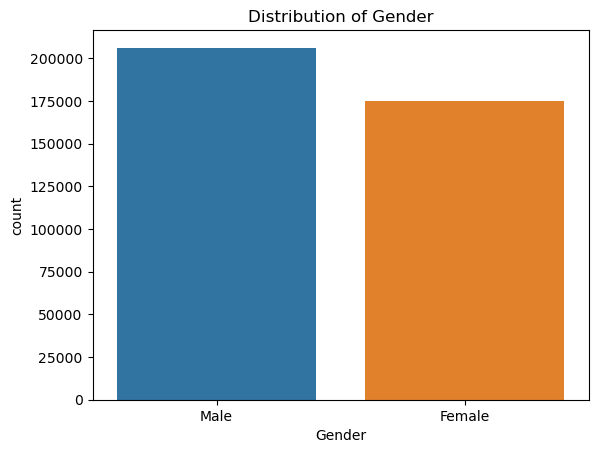

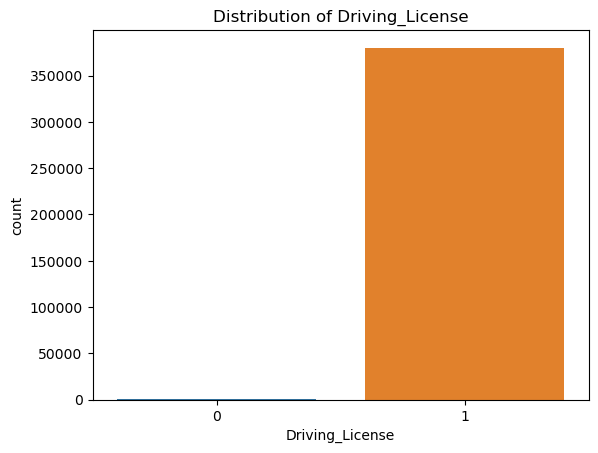

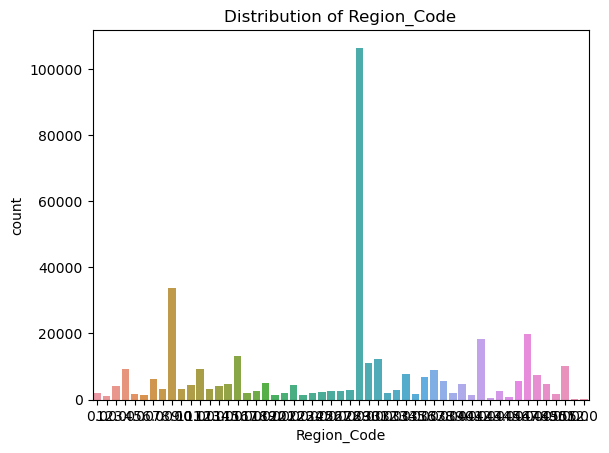

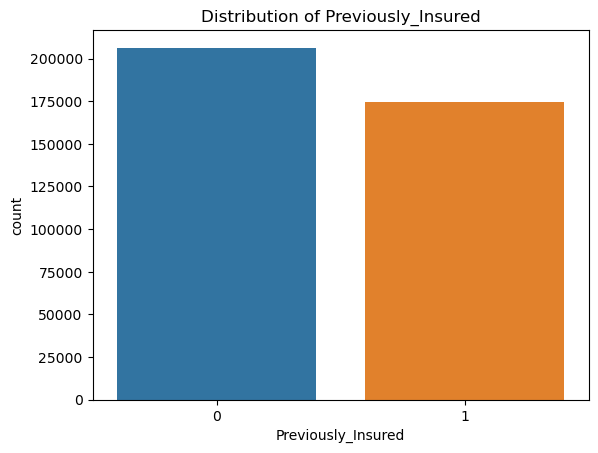

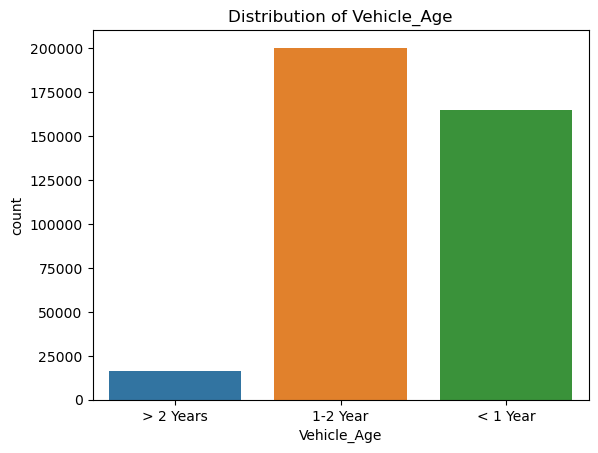

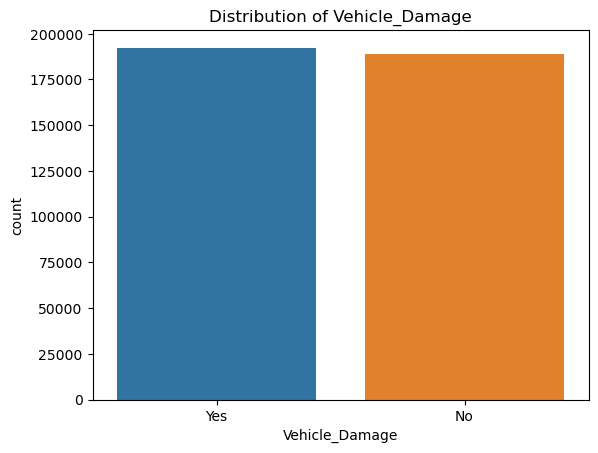

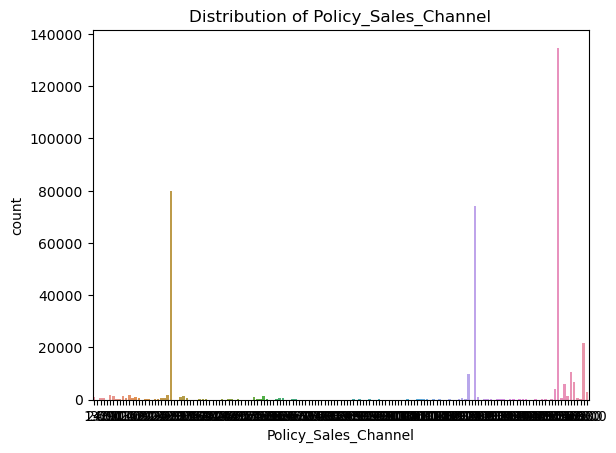

In [9]:
# Distributions of the categorical features

for var in cat_var:
    sns.countplot(x = var, data = df_train)
    plt.title(f'Distribution of {var}')
    plt.show()

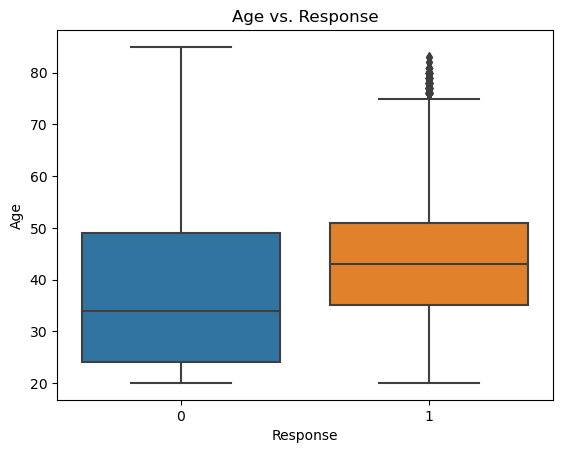

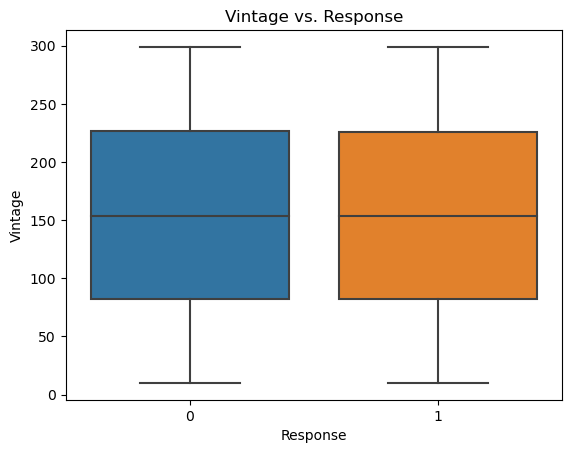

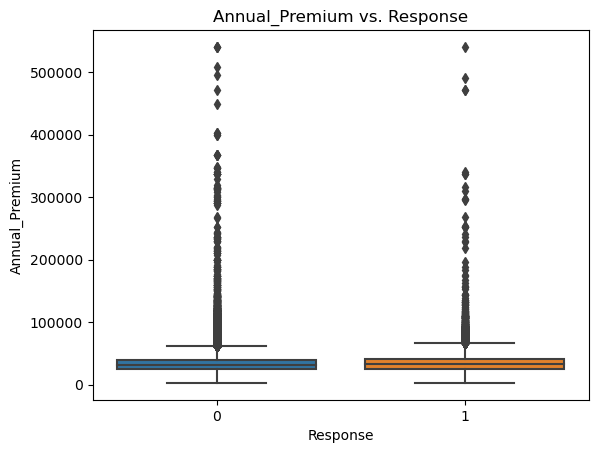

In [10]:
# Relationship between quantitative features and the target variable

"""
We can notice that the Age can be a factor on the forecasted response of 
the customer, as the older ones tend to respond more positively to the offer.
"""

for var in num_var:
    sns.boxplot(x = 'Response', y = var, data = df_train)
    plt.title(f'{var} vs. Response')
    plt.show()


### Feature Encoding

In [11]:
# Encoding the categorical features with the LabelEncoder

LabEnc = LabelEncoder()
df_train['Gender'] = LabEnc.fit_transform(df_train['Gender'])
df_test['Gender'] = LabEnc.transform(df_test['Gender'])

LabEnc = LabelEncoder()
df_train['Vehicle_Damage'] = LabEnc.fit_transform(df_train['Vehicle_Damage'])
df_test['Vehicle_Damage'] = LabEnc.transform(df_test['Vehicle_Damage'])

df_train["Region_Code"] = df_train["Region_Code"].astype("str")
df_test["Region_Code"] = df_test["Region_Code"].astype("str")
LabEnc = LabelEncoder()
df_train['Region_Code'] = LabEnc.fit_transform(df_train['Region_Code'])
df_test['Region_Code'] = LabEnc.transform(df_test['Region_Code'])

Vehicle_Age = {'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}
df_train['Vehicle_Age'] = df_train['Vehicle_Age'].map(Vehicle_Age)
df_test['Vehicle_Age'] = df_test['Vehicle_Age'].map(Vehicle_Age)

In [12]:
StdScl = StandardScaler()

df_train[num_var] = StdScl.fit_transform(df_train[num_var])
df_test[num_var] = StdScl.transform(df_test[num_var])

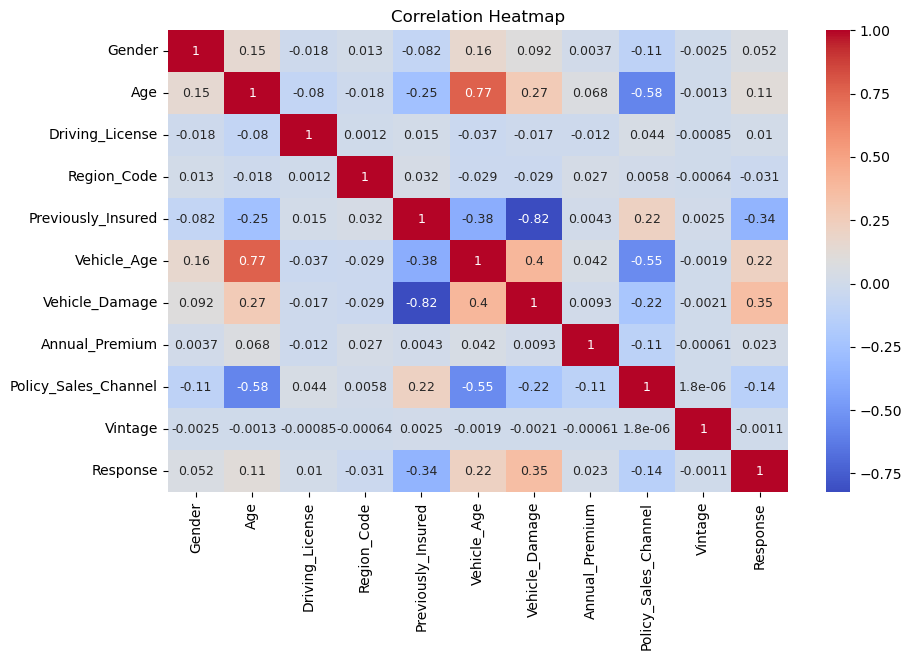

In [13]:
"""
The features that are most correlated with the target variable seem to be 
'Vehicle_Damage' (positively correlated) and 'Previously_Insured' 
(negatively correlated). This makes sense, as customers who have had an 
incident in the past will be more likely to take out an insurance policy. 
Those who already have an insured vehicle, are more unlikely to have an 
additional vehicle to insure.
"""

plt.figure(figsize=(10, 6))
sns.heatmap(df_train.corr(), annot = True, annot_kws = {'size': 9}, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# Checking if the feature encoding had effect on the dataset

df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0.333777,1,21,0,2,1,0.574539,26.0,0.748795,1
1,1,2.396751,1,23,0,1,0,0.172636,26.0,0.342443,0
2,1,0.527181,1,21,0,2,1,0.449053,26.0,-1.521998,1
3,1,-1.148985,1,3,1,0,0,-0.113018,152.0,0.581474,0
4,0,-0.633242,1,36,1,0,0,-0.178259,152.0,-1.378580,0


### Training models

In [15]:
# Setting a constant 'RS' (RANDOM_SEED) for the 'random_state' attirbute
RS = 25

# Splitting the variables into features and target
X = df_train.drop(['Response'], axis=1)
y = df_train['Response']

In [16]:
"""
We use the 'stratify' parameter to ensure that the distribution of the target variable 'Response' 
is preserved in both the training and testing sets. 
By setting the 'shuffle' parameter as True, we want to avoid any possible ordering in the dataset,
like taking all the observations for our test set from one specific Region Code.
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS, stratify=y, shuffle=True)

In [17]:
"""
By performing oversampling with the SMOTE_NC method (an extension of the SMOTE algorithm) 
we are able to effectively handles datasets with both quantitative and categorical features.
https://imbalanced-learn.org/stable/over_sampling.html
"""

cat_var_mask = X.columns.isin(cat_var)

smotenc = SMOTENC(categorical_features=cat_var_mask, random_state=RS)
X, y = smotenc.fit_resample(X_train, y_train)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### RandomForestClassifier

In [ ]:
RanFor = RandomForestClassifier(n_estimators=62, max_depth=17, random_state=RS, class_weight='balanced')

RanFor.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=62,
                       random_state=25)

In [ ]:
y_pred_train = RanFor.predict(X_train)
y_proba_train = RanFor.predict_proba(X_train)
y_pred_test = RanFor.predict(X_test)
y_proba_test = RanFor.predict_proba(X_test)

print("TRAIN REPORT - RandomForestClassifier")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT - RandomForestClassifier")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.97      0.74      0.84    250799
           1       0.79      0.98      0.88    250799

    accuracy                           0.86    501598
   macro avg       0.88      0.86      0.86    501598
weighted avg       0.88      0.86      0.86    501598

TEST REPORT - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     83600
           1       0.78      0.96      0.86     83600

    accuracy                           0.85    167200
   macro avg       0.87      0.85      0.84    167200
weighted avg       0.87      0.85      0.84    167200



In [ ]:
y_proba_train = RanFor.predict_proba(X_train)[:, 1]
y_proba_test = RanFor.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_train, y_proba_train))
print(roc_auc_score(y_test, y_proba_test))

0.9341240256566092
0.9221417739549231


In [ ]:
"""
Let's comment the result obtained with the RandomForestClassifier:

For class 0, we have high precision but low recall. This means that when 
the model predicts a customer is in class 0 (not interested), it is often 
correct, but it misses a large portion of the total actual 0s, so it 
wrongly classifies many actual 0s (not interested) as 1s (interested).

For class 1, we have lower precision but higher recall. This means the model 
identifies a high proportion of actual 1s (interested) correctly, but in 
doing so, it also wrongly identifies many 0s (not interested) as 1s 
(interested), leading to a high number of false positives."

The ROC-AUC score of 92.21% on the test is actually not a bad result.
Being this model more liberal on class 1, it could be useful for 
initial broad-based marketing efforts.

Let's see if we can find a more precise model though...
"""

### CatBoostClassifier

In [ ]:
CatBst = CatBoostClassifier(verbose=100)

CatBst.fit(X_train, y_train, eval_set = (X_test, y_test), early_stopping_rounds=10)

Learning rate set to 0.147196
0:	learn: 0.5669675	test: 0.5665808	best: 0.5665808 (0)	total: 240ms	remaining: 3m 59s
100:	learn: 0.2577065	test: 0.2583314	best: 0.2583314 (100)	total: 6.3s	remaining: 56.1s
200:	learn: 0.2382472	test: 0.2396875	best: 0.2396875 (200)	total: 12.1s	remaining: 47.9s
300:	learn: 0.2334525	test: 0.2360355	best: 0.2360355 (300)	total: 17.9s	remaining: 41.6s
400:	learn: 0.2302202	test: 0.2340340	best: 0.2340340 (400)	total: 23.8s	remaining: 35.6s
500:	learn: 0.2277621	test: 0.2325626	best: 0.2325626 (500)	total: 30.3s	remaining: 30.2s
600:	learn: 0.2249504	test: 0.2307865	best: 0.2307865 (600)	total: 36.9s	remaining: 24.5s
700:	learn: 0.2230841	test: 0.2299552	best: 0.2299552 (700)	total: 43.7s	remaining: 18.6s
800:	learn: 0.2213969	test: 0.2292568	best: 0.2292523 (799)	total: 50.2s	remaining: 12.5s
900:	learn: 0.2197585	test: 0.2286132	best: 0.2286088 (898)	total: 56.7s	remaining: 6.23s
999:	learn: 0.2183322	test: 0.2281567	best: 0.2281567 (999)	total: 1m 3s	r

In [ ]:
y_pred_train = CatBst.predict(X_train)
y_proba_train = CatBst.predict_proba(X_train)
y_pred_test = CatBst.predict(X_test)
y_proba_test = CatBst.predict_proba(X_test)

print("TRAIN REPORT - CatBoostClassifier")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT - CatBoostClassifier")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT - CatBoostClassifier
              precision    recall  f1-score   support

           0       0.88      0.90      0.89    250799
           1       0.89      0.87      0.88    250799

    accuracy                           0.88    501598
   macro avg       0.89      0.88      0.88    501598
weighted avg       0.89      0.88      0.88    501598

TEST REPORT - CatBoostClassifier
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     83600
           1       0.89      0.87      0.88     83600

    accuracy                           0.88    167200
   macro avg       0.88      0.88      0.88    167200
weighted avg       0.88      0.88      0.88    167200



In [ ]:
y_proba_train = CatBst.predict_proba(X_train)[:, 1]
y_proba_test = CatBst.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_train, y_proba_train))
print(roc_auc_score(y_test, y_proba_test))

0.9672313353452457
0.962744242061766


In [ ]:
"""
The CatBoostClassifier gave a ROC-AUC score of 96.27% on the test set.
It suggests that the model can accurately identify positive instances 
while keeping the number of false positives low.
"""

### XGBClassifier

In [ ]:
"""
XGBC = XGBClassifier(random_state=RS)
XGBC.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=25, ...)

In [ ]:
"""
y_pred_train = XGBC.predict(X_train)
y_proba_train = XGBC.predict_proba(X_train)
y_pred_test = XGBC.predict(X_test)
y_proba_test = XGBC.predict_proba(X_test)

print("TRAIN REPORT - XGBClassifier")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT - XGBClassifier")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT - XGBClassifier
              precision    recall  f1-score   support

           0       0.90      0.87      0.88    250799
           1       0.88      0.90      0.89    250799

    accuracy                           0.89    501598
   macro avg       0.89      0.89      0.89    501598
weighted avg       0.89      0.89      0.89    501598

TEST REPORT - XGBClassifier
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     83600
           1       0.87      0.89      0.88     83600

    accuracy                           0.88    167200
   macro avg       0.88      0.88      0.88    167200
weighted avg       0.88      0.88      0.88    167200



In [ ]:
"""
y_proba_train = XGBC.predict_proba(X_train)[:, 1]
y_proba_test = XGBC.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_train, y_proba_train))
print(roc_auc_score(y_test, y_proba_test))

0.9679036422125282
0.965178048736865


In [ ]:
""" 
With a ROC-AUC of 96.51% on the test set, the XGBClassifier represents
an improvement on the CatBoostClassifier, and it also proved to be
less computationally expensive.
We are going to use this model for our predictions on the test set:
"""

In [ ]:
"""
# Applying the model to the test data
df_test_id = df_test['id']
df_test = df_test.drop(['id'], axis=1)
df_test_pred = XGBC.predict(df_test)
df_test_pred_proba = XGBC.predict_proba(df_test)

# Creating a new dataframe for the predictions
df_predictions = pd.DataFrame({
    'id': df_test_id,
    'Response': df_test_pred,
    'Probability_0': df_test_pred_proba[:, 0],
    'Probability_1': df_test_pred_proba[:, 1]
})

df_predictions.to_excel(BASE_URL + 'vehicle_insurance_predictions.xlsx', index=False)


### GradientBoostingClassifier

In [ ]:
GrdBst = GradientBoostingClassifier(random_state=RS)

GrdBst.fit(X_train, y_train)

GradientBoostingClassifier(random_state=25)

In [ ]:
y_pred_train = GrdBst.predict(X_train)
y_proba_train = GrdBst.predict_proba(X_train)
y_pred_test = GrdBst.predict(X_test)
y_proba_test = GrdBst.predict_proba(X_test)

print("TRAIN REPORT - GradientBoostingClassifier")
print(classification_report(y_train, y_pred_train))
print("TEST REPORT - GradientBoostingClassifier")
print(classification_report(y_test, y_pred_test))

TRAIN REPORT - GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.95      0.68      0.79    250799
           1       0.75      0.96      0.84    250799

    accuracy                           0.82    501598
   macro avg       0.85      0.82      0.82    501598
weighted avg       0.85      0.82      0.82    501598

TEST REPORT - GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     83600
           1       0.75      0.96      0.84     83600

    accuracy                           0.82    167200
   macro avg       0.85      0.82      0.82    167200
weighted avg       0.85      0.82      0.82    167200



In [ ]:
y_proba_train = GrdBst.predict_proba(X_train)[:, 1]
y_proba_test = GrdBst.predict_proba(X_test)[:, 1]

print(roc_auc_score(y_train, y_proba_train))
print(roc_auc_score(y_test, y_proba_test))

0.9018768346636599
0.9015216733247865


In [ ]:
"""
The GradientBoostingClassifier shows many false positive, even more than
the RandomForestClassifier, and it actually doesn't represent an 
improvement over any of the model we saw above.
"""